Importation de packages et de librairies

In [10]:
import pandas as pd
import numpy as np
import openpyxl as xl
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller
from tabulate import tabulate
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
import statsmodels.api as sm


Importation de la base de donnees

In [7]:
df=pd.read_excel("DATAN.xlsx")
df

,An,Recettes,PIB,IPC,CHANGE
0,2000,-0.079310,0.9,17.083779,24.124092
1,2001,0.024587,-1.1,9.351166,26.880425
2,2002,0.249492,-0.5,24.368735,39.616983
3,2003,-0.393419,0.5,29.776429,39.896517
4,2004,0.209723,-3.8,17.652600,38.712942
5,2005,0.006617,1.8,14.455228,41.672350
6,2006,0.518616,2.2,9.358333,37.515508
7,2007,0.256379,3.3,13.283333,38.108637
8,2008,-0.587035,0.8,5.839022,40.609485
9,2009,1.945389,3.0,3.414330,40.294196


exploration de donnees

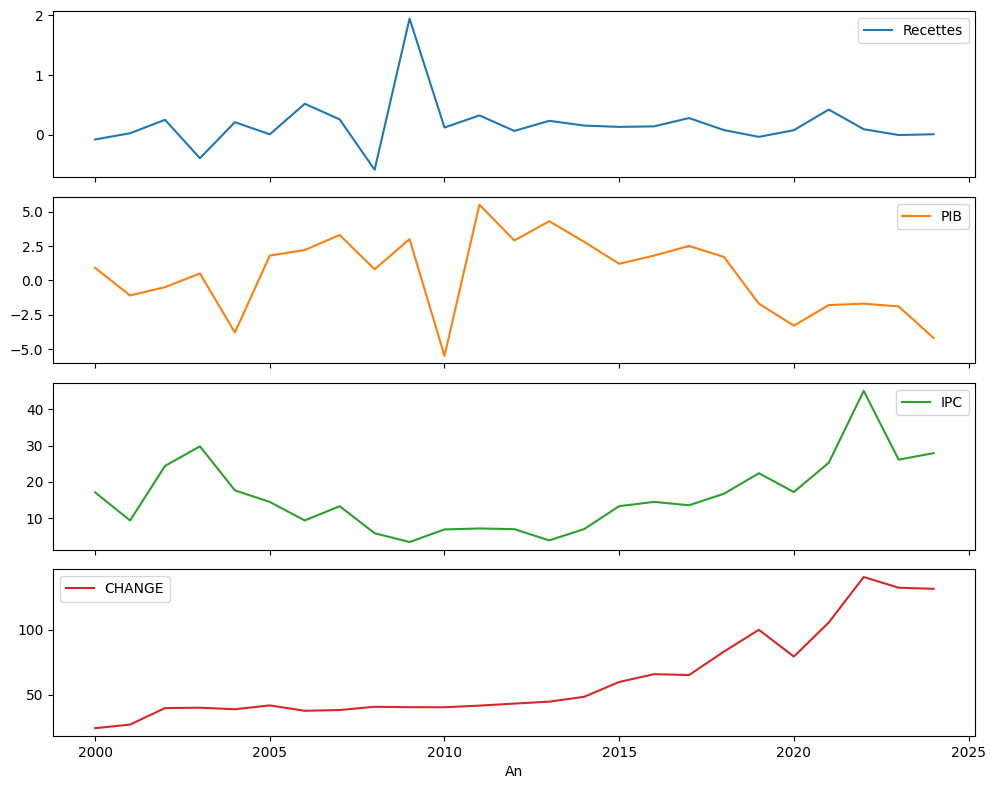

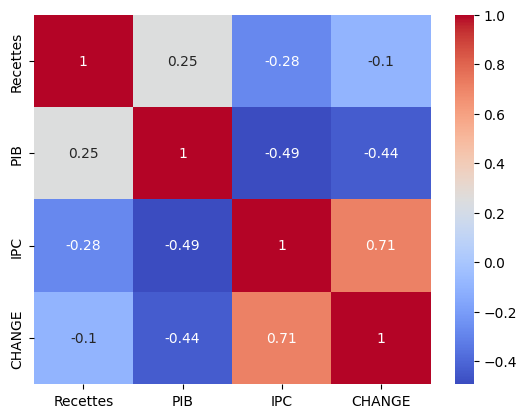

In [8]:
# Courbes d’évolution
df.set_index('An')[['Recettes', 'PIB', 'IPC', 'CHANGE']].plot(subplots=True, figsize=(10, 8))
plt.tight_layout()
plt.show()

# Corrélations
sns.heatmap(df[['Recettes', 'PIB', 'IPC', 'CHANGE']].corr(), annot=True, cmap='coolwarm')
plt.show()


Test de stationnarité pour les series

In [9]:
def adf_test(series, name):
    result = adfuller(series.dropna())
    print(f"ADF Test for {name}:")
    print(f"  ADF Statistic: {result[0]:.4f}")
    print(f"  p-value: {result[1]:.4f}")
    print("  Stationary" if result[1] < 0.05 else "  Non-stationary")
    print("-" * 40)

for col in ['Recettes', 'PIB', 'IPC', 'CHANGE']:
    adf_test(df[col], col)


ADF Test for Recettes:
  ADF Statistic: -6.7968
  p-value: 0.0000
  Stationary
----------------------------------------
ADF Test for PIB:
  ADF Statistic: -1.7274
  p-value: 0.4171
  Non-stationary
----------------------------------------
ADF Test for IPC:
  ADF Statistic: -0.0246
  p-value: 0.9565
  Non-stationary
----------------------------------------
ADF Test for CHANGE:
  ADF Statistic: 2.1277
  p-value: 0.9988
  Non-stationary
----------------------------------------


In [12]:
# Étape 1 : Régression sur les niveaux
X = df[['PIB', 'IPC', 'CHANGE']]
X = sm.add_constant(X)
y = df['Recettes']
model = sm.OLS(y, X).fit()

# Étape 2 : Tester la stationnarité des résidus
residuals = model.resid
result = adfuller(residuals)
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("  Stationary" if result[1] < 0.05 else "  Non-stationary")

ADF Statistic: -6.810443919307012
p-value: 2.1229969884472065e-09
  Stationary
